In [38]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
class NumpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to train or val directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([cls for cls in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, cls))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_path):
                if fname.endswith(".npy"):
                    self.samples.append((os.path.join(cls_path, fname), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)  # Load .npy file
        data = torch.from_numpy(data).float()  # Convert to tensor

        if self.transform:
            data = self.transform(data)

        return data, label

# Define transforms (modify if needed)
transform = transforms.Compose([
    transforms.RandomAffine(degrees=90, translate=(0.1, 0.1)),  # Rotate ±30°, Translate ±10%
])

In [26]:
train_dir = "dataset/dataset/train"
val_dir = "dataset/dataset/val"

# Load datasets
train_dataset = NumpyDataset(train_dir, transform=transform)
val_dataset = NumpyDataset(val_dir)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Test loading one batch
sample_batch, sample_labels = next(iter(train_loader))
print("Batch shape:", sample_batch.shape)
print("Labels:", sample_labels)

Batch shape: torch.Size([32, 1, 150, 150])
Labels: tensor([2, 2, 1, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0,
        2, 0, 2, 1, 1, 0, 0, 0])


In [27]:
# Function to visualize dataset samples
def visualize_samples(dataset, num_samples=5):
    """
    Displays `num_samples` images from each class in the dataset.
    """
    class_samples = {cls: [] for cls in dataset.class_to_idx.keys()}  # Dictionary to store samples per class
    
    # Collect samples from the dataset
    for img, label in dataset:
        class_name = list(dataset.class_to_idx.keys())[label]
        if len(class_samples[class_name]) < num_samples:
            class_samples[class_name].append(img)
        if all(len(v) >= num_samples for v in class_samples.values()):  # Stop when enough samples collected
            break

    # Plot images
    fig, axes = plt.subplots(len(class_samples), num_samples, figsize=(num_samples * 2, len(class_samples) * 2))
    fig.suptitle("Dataset Visualization", fontsize=16)

    for row, (class_name, images) in enumerate(class_samples.items()):
        for col, img in enumerate(images):
            ax = axes[row, col] if len(class_samples) > 1 else axes[col]
            ax.imshow(img.squeeze(), cmap='gray')  # Assuming single-channel images
            ax.set_title(class_name)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

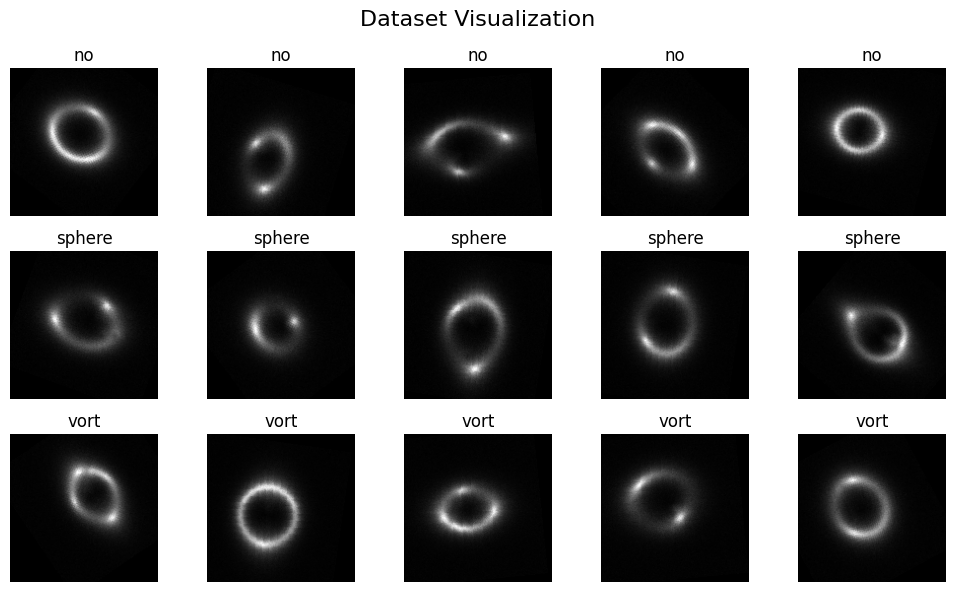

In [28]:
visualize_samples(train_dataset)

In [23]:
class LensClassifierCNN(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(LensClassifierCNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = torch.nn.MaxPool2d(2, 2)

        # Global Average Pooling instead of Flattening
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d(1)  # Output size = (batch, channels, 1, 1)

        self.fc = torch.nn.Linear(128, num_classes)  # Only needs to match number of channels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.global_avg_pool(x)  # Output shape: (batch, 128, 1, 1)
        x = torch.flatten(x, start_dim=1)  # Flatten only (batch, 128)
        
        x = self.fc(x)  # Final classification layer
        return x

In [28]:
model = LensClassifierCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.31it/s]


Epoch 1/10, Loss: 1.0989289357463943


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.25it/s]


Epoch 2/10, Loss: 1.0987614244540362


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.07it/s]


Epoch 3/10, Loss: 1.0987254963246489


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.20it/s]


Epoch 4/10, Loss: 1.0987316078977036


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.18it/s]


Epoch 5/10, Loss: 1.0987467932294426


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.25it/s]


Epoch 6/10, Loss: 1.0987208859244388


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.29it/s]


Epoch 7/10, Loss: 1.0986743255464761


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.26it/s]


Epoch 8/10, Loss: 1.0987177149319192


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.33it/s]


Epoch 9/10, Loss: 1.0987087847835728


100%|█████████████████████████████████████████| 938/938 [00:35<00:00, 26.31it/s]

Epoch 10/10, Loss: 1.0987016490019206


In [43]:
# Evaluation Function
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute ROC AUC Score
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
    print(f"Validation ROC AUC Score: {auc:.4f}")

def plot_roc_curve(model, dataloader, class_to_idx, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get raw logits
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            
            y_true.extend(labels.cpu().numpy())  
            y_scores.extend(probabilities.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Get class names
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]

    # One-hot encode true labels
    y_true_one_hot = label_binarize(y_true, classes=np.arange(len(class_to_idx)))

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    # Plot random baseline
    plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

    # Formatting
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Run Evaluation
#evaluate(model, val_loader)


In [22]:
class ResNetFineTune(torch.nn.Module):
    def __init__(self, num_classes=3, freeze_blocks=2):
        super(ResNetFineTune, self).__init__()

        self.conv1x3 = torch.nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Load Pretrained ResNet (e.g., resnet18 or resnet50)
        self.base_model = models.resnet18(pretrained=True)  # Change to resnet50 if needed
        
        # Freeze first few blocks to retain general feature extraction
        num_layers_to_freeze = freeze_blocks * 2  # Each ResNet block contains 2 layers
        layers = list(self.base_model.children())[:num_layers_to_freeze]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

        # Remove the original FC layer
        self.base_model = torch.nn.Sequential(*list(self.base_model.children())[:-2])  # Keep up to last conv layer
        
        # Add Global Average Pooling
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d(1)

        # Custom Classification Head
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 256),  # 512 for ResNet18, change to 2048 for ResNet50
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1x3(x)
        x = self.base_model(x)  # Feature extraction
        x = self.global_avg_pool(x)  # GAP -> Shape: (batch, 512, 1, 1)
        x = torch.flatten(x, start_dim=1)  # Shape: (batch, 512)
        x = self.classifier(x)  # Custom head
        return x


In [32]:
model = ResNetFineTune(freeze_blocks=0).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda')

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()  # Scale loss before backward pass
        scaler.step(optimizer)  # Update weights
        scaler.update()

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            total_val_loss += loss.item()
            
            # Compute accuracy
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total_samples * 100

    # Print epoch results
    print(f"\n🔥 Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

/tmp/ipykernel_12072/495084994.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision
Epoch 1/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.23it/s]
/tmp/ipykernel_12072/495084994.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                


🔥 Epoch 1/10 | Train Loss: 0.9407 | Val Loss: 0.6986 | Val Accuracy: 69.95%


Epoch 2/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.24it/s]
                                                                                


🔥 Epoch 2/10 | Train Loss: 0.6351 | Val Loss: 0.6121 | Val Accuracy: 73.25%


Epoch 3/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.21it/s]
                                                                                


🔥 Epoch 3/10 | Train Loss: 0.5318 | Val Loss: 0.5282 | Val Accuracy: 78.61%


Epoch 4/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.23it/s]
                                                                                


🔥 Epoch 4/10 | Train Loss: 0.4738 | Val Loss: 0.3974 | Val Accuracy: 84.12%


Epoch 5/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.26it/s]
                                                                                


🔥 Epoch 5/10 | Train Loss: 0.4345 | Val Loss: 0.3263 | Val Accuracy: 87.76%


Epoch 6/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.24it/s]
                                                                                


🔥 Epoch 6/10 | Train Loss: 0.4033 | Val Loss: 0.3201 | Val Accuracy: 87.68%


Epoch 7/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.23it/s]
                                                                                


🔥 Epoch 7/10 | Train Loss: 0.3793 | Val Loss: 0.3208 | Val Accuracy: 88.13%


Epoch 8/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.23it/s]
                                                                                


🔥 Epoch 8/10 | Train Loss: 0.3588 | Val Loss: 0.3164 | Val Accuracy: 88.08%


Epoch 9/10 - Training: 100%|██████████████████| 938/938 [00:51<00:00, 18.28it/s]
                                                                                


🔥 Epoch 9/10 | Train Loss: 0.3417 | Val Loss: 0.2907 | Val Accuracy: 88.72%


Epoch 10/10 - Training: 100%|█████████████████| 938/938 [00:51<00:00, 18.27it/s]
                                                                                


🔥 Epoch 10/10 | Train Loss: 0.3256 | Val Loss: 0.3106 | Val Accuracy: 87.97%


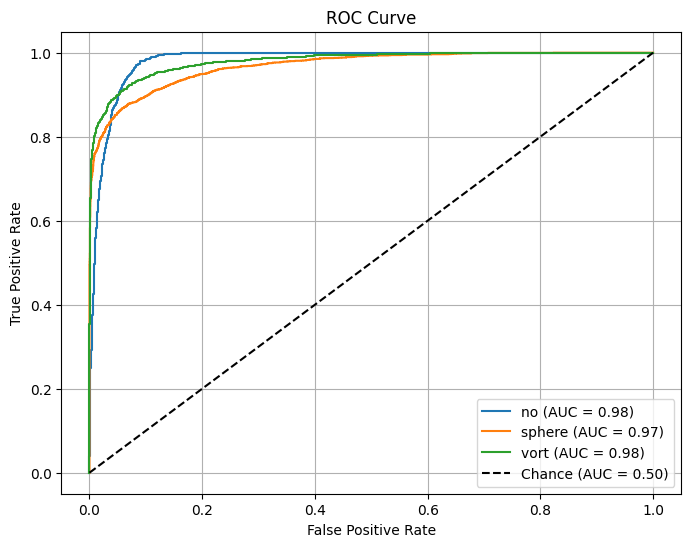

Validation ROC AUC Score: 0.9765


In [45]:
plot_roc_curve(model, val_loader, val_dataset.class_to_idx, device)
evaluate(model, val_loader)